In [1]:
import numpy as np
import numexpr as ne
from math import pi
from scipy.optimize import newton
from scipy.signal import hilbert
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

from novice_stakes.surfaces import Surface, spectrum
from novice_stakes import initialize_nuttall
from novice_stakes.refraction import p_sca_KA_fan, IsoSpeedFan, initialize_axes

In [5]:
z_src = -10.
z_rcr = -20.
x_rcr = 200.

# sinusoidal surface parameters
H = 2.
L = 40.
K = 2 * pi / L

# compute time/frequency domain parameters
c = 1500
fc = 4e3
fs = 2.1 * fc * 2
tau_lim = 10e-3

faxis, dx, sig_FT = initialize_nuttall(fc, fs, c, tau_lim)
kmax = 2 * pi / dx

# compute source and receiver ray fans
dz_iso = 2
num_rays = 2000
theta_max = 0.1 * (pi / 180)

ray_src = IsoSpeedFan(c, z_src + dz_iso, num_rays, theta_max)
ray_rcr = IsoSpeedFan(c, z_rcr + dz_iso, num_rays, theta_max)

# setup xaxis
xaxis, yaxis, tau_img = initialize_axes(ray_src, ray_rcr, tau_lim, x_rcr, dx, dz_iso=dz_iso)

kx = np.arange(xaxis.size // 2 + 1) * kmax / xaxis.size
ky = (np.arange(yaxis.size) - (yaxis.size // 2 - 1)) * kmax / yaxis.size

In [6]:
num_times = 50.
total_time = 5.
twave = np.arange(num_times) * total_time / num_times
surf_1D = Surface(K, H / (2 * np.sqrt(2)), xaxis=xaxis)
p_stack = []

for wt in twave: 
    realization_1D = surf_1D.realization()

    eta = surf_1D.surface_synthesis(realization_1D, time=wt)
    eta_p = surf_1D.surface_synthesis(realization_1D, derivative='x', time=wt)

    p_rcr, taxis, p_ref = p_sca_KA_fan(ray_src, ray_rcr, xaxis, x_rcr,
                                       eta, eta_p, tau_img, tau_lim, 
                                       faxis, sig_FT, tau_start=-1, dz_iso=dz_iso)
    p_stack.append(p_rcr)
    
p_stack = np.array(p_stack)

Text(0, 0.5, 'Delay re. image arrival (ms)')

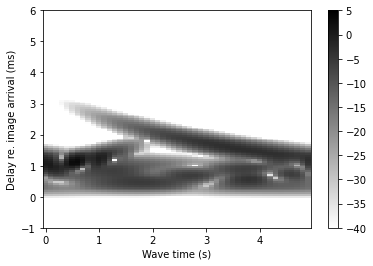

In [7]:
p_dB = 20 * np.log10(np.abs(hilbert(p_stack, axis=-1))) - 20 * np.log10(p_ref)
fig, ax = plt.subplots()
cm = ax.pcolormesh(twave, (taxis - tau_img) * 1e3, p_dB.T, cmap=plt.cm.binary, vmin=-40, vmax=5)
fig.colorbar(cm)
ax.set_ylim(-1, 6)
ax.set_xlabel('Wave time (s)')
ax.set_ylabel('Delay re. image arrival (ms)')